### Introduction

<span style="color:#7E96A0">Purpose: This notebook presents an analysis of the SnackChain dataset as part of the final project for ISM6137 - Advanced Statistical Modeling. The dataset includes sales and promotional data for various snack products across a chain of retail stores. The objective is to demonstrate proficiency in data cleaning, exploratory data analysis (EDA), and statistical modeling to uncover insights related to product performance and pricing strategies</span>

<span style="color:#7E96A0">ISM6137 - Advanced Statistical Modeling (Spring 2025)<br>
School of Information Systems & Management, University of South Florida<br>
Dr. Daniel Zantedeschi, Ph.D.
</span>

<span style="color:#7E96A0">Project Team Members: <br>
**Daniel Feler<br>
Domenick Dobbs<br>
James Burnett**
</span>

<span style="color:#816d69"> *Note: AI platforms (e.g. ChatGPT, Gemini, Copilot) were used intermittently throughout this project to assist with the creation of this project's code, general cleaning, and the conceptual understanding and application of statistical principles discussed in class. While these resources helped the team turn in a better, cleaner, more intuitive product, ownership is fully retained with the team and can be demonstrated as needed.*</span>

### <a id="top"></a>Navigation
##### Click to jump to:
[Data Cleaning](#data_cln)  
[Feature Encoding](#feature_enc)  
[Feature Engineering](#feature_eng)  
[Model Creation (Q1)](#model_creation)  
[Elasticity Evaluation (Q3)](#prc_elas)  
[Pricing Strategy (Q4)](#prc_strat)  


### Data Preparation & Cleaning

### Import Toolbox

In [27]:
import category_encoders as ce
import re                               # Extraction of text
import pandas as pd                     # Data manipulation
import numpy as np                      # Numeric computations
import matplotlib.pyplot as plt         # Plotting
import seaborn as sns                   # Visualizations
import statsmodels.api as sm            # Regression
from sklearn.preprocessing import OneHotEncoder # Encoding
from itertools import combinations

### Import & Merge Datasets

In [28]:
# Import the stores.xlsx file
df_transactions = pd.read_excel('snack_chain_2.xlsx', sheet_name='transactions')
df_products = pd.read_excel('snack_chain_2.xlsx', sheet_name='products')
df_stores = pd.read_excel('snack_chain_2.xlsx', sheet_name='stores')

In [29]:
df_stores.rename(columns={'STORE_ID': 'STORE_NUM', 'SIZE': 'STORE_SQFT'}, inplace=True)
df_transactions.rename(columns={'SPEND': 'TOT_SPEND', 'UNITS': 'UNITS_SOLD', 'VISITS': 'NUM_VISITS'}, inplace=True)

In [30]:
# Merge 'Transactions' with 'Products' on UPC to create df_temp
df_temp = pd.merge(df_transactions, df_products, on='UPC', how='left')

# Merge df_temp with 'Stores' to create df
df = pd.merge(df_temp, df_stores, on='STORE_NUM', how='left')

In [31]:
# Free up memory by removing intermediate data frames
del df_transactions, df_stores

### <a id="data_cln"></a>Data Cleaning  
[⬆️ Back to Top](#top)

In [32]:
# Convert column headers to lowercase
df.columns = df.columns.str.lower()
# Convert column data to lower case
df = df.map(lambda x: x.lower() if isinstance(x, str) else x)

In [33]:
df.isna().sum()

week_end_date              0
store_num                  0
upc                        0
units_sold                 0
num_visits                 0
hhs                        0
tot_spend                  0
price                     23
base_price               185
feature                    0
display                    0
tpr_only                   0
description                0
manufacturer               0
category                   0
sub_category               0
product_size               0
store_name                 0
city                       0
state                      0
msa                        0
segment                    0
parking               366061
store_sqft                 0
avg_weekly_baskets         0
dtype: int64

In [34]:
# Create A separate DataFrame for upc and description (used later)
product_names = df[['upc', 'description']].drop_duplicates()

##### Drop Un-needed Elements

In [35]:
df = df.dropna(subset=['price', 'base_price']) # Drop rows where price or base_price is empty
df.drop(columns=['parking', 'description'], inplace=True) # Drop 'parking' and 'description' columns
df = df[df['category'] != 'oral hygiene products'] # Drop 'oral hygiene' product category

In [36]:
print(df['category'].unique())  # Should NOT include 'oral hygiene products'
print(df[df['category'] == 'oral hygiene products'])  # Should return an empty DataFrame

['bag snacks' 'cold cereal' 'frozen pizza']
Empty DataFrame
Columns: [week_end_date, store_num, upc, units_sold, num_visits, hhs, tot_spend, price, base_price, feature, display, tpr_only, manufacturer, category, sub_category, product_size, store_name, city, state, msa, segment, store_sqft, avg_weekly_baskets]
Index: []

[0 rows x 23 columns]


##### Standardize Product Size

In [37]:
# Standardize the product size to ml
# Function to extract numeric value and unit using regex
def extract_size_details(size):
    """
    Extracts a numeric value and unit from a product_size string using regex.
    
    Args:
        size (str): A string representing the product size (e.g., "15 OZ", "1.5 LT").
    
    Returns:
        pd.Series: A pandas Series containing the extracted value (float) and unit (str).
    """
    if isinstance(size, str):
        match = re.match(r"(\d*\.?\d+)\s*([a-zA-Z]+)", size)  # Extract number and unit
        if match:
            return pd.Series([float(match.group(1)), match.group(2).lower()])
    return pd.Series([None, None])  # Handle missing or incorrect formats

# Apply function to extract size and unit safely
df[['size_value', 'size_unit']] = df['product_size'].apply(extract_size_details)

# Define conversion rates in a dictionary
conversion_rates = {"ml": 1, "oz": 29.5735, "lt": 1000}

# size_in_ml is now standardized accross all products 
df['size_in_ml'] = df.apply(
    lambda row: row['size_value'] * conversion_rates.get(row['size_unit'], np.nan)
    if pd.notna(row['size_value']) and pd.notna(row['size_unit']) else np.nan, axis=1
)

In [38]:
# Drop additional columns as well as the original product_size column since it's no longer needed
df.drop(columns=['product_size', 'size_value', 'size_unit', 'manufacturer', 'city', 'store_name'], inplace=True)
# manufacturer, city, and store name doesn't help us, and they're not ideal for encoding so we dropped them

### <a id="feature_enc"></a>Feature Encoding  
[⬆️ Back to Top](#top)

In [39]:
# BINARY encoding
binary_cols = ['state', 'category', 'segment'] # Columns to binary encode
binary_encoder = ce.BinaryEncoder(cols=binary_cols) # Initialize encoder
df_encoded = binary_encoder.fit_transform(df[binary_cols]) # Fit and transform
# Drop original categorical columns and concat encoded binary columns
df = pd.concat([df.drop(columns=binary_cols), df_encoded], axis=1)

# ONE-HOT Encode category, sub_category, state, and segment
encoder = OneHotEncoder(sparse_output=False, drop=None)  # Keep all categories
categorical_cols = ['sub_category']
encoded_data = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))
# Drop original categorical columns and concat encoded OHE columns
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

### <a id="feature_eng"></a>Feature Engineering  
[⬆️ Back to Top](#top)

<span style="color:#7E96A0">The discount_pct variable calculates the percentage discount given on a product by comparing the base price to the actual selling price:</span>

In [40]:
df['discount_pct'] = ((df['base_price'] - df['price']) / df['base_price']) * 100

# Fill missing values with median for all numeric columns
df = df.fillna(df.median(numeric_only=True))

<span style="color:#7E96A0">This helps us measure how much of a markdown each product received. In the context of this project, it allows us to evaluate whether larger discounts lead to increased spending, units sold, or store visits—making it a critical feature when assessing the impact of promotional pricing strategies on consumer behavior.</span>

### Interaction terms

<span style="color:#7E96A0">This block creates interaction terms between two variables — specifically, whether a product was featured in a circular (df['feature']) and either:<br>
• A product category, like 'sub_category_all family cereal' or 'sub_category_pizza/premium', or<br>
• A store segment, like 'segment_0' or 'segment_1'.<br>

These lines of code multiply the binary “feature” column (1 = featured, 0 = not featured) by binary columns that represent product categories or store segments.</span>

In [41]:
df['feature_x_family_cereal'] = df['feature'] * df['sub_category_all family cereal']
df['feature_x_kids_cereal'] = df['feature'] * df['sub_category_kids cereal']
df['feature_x_pizza'] = df['feature'] * df['sub_category_pizza/premium']
df['feature_x_pretzels'] = df['feature'] * df['sub_category_pretzels']
df['feature_x_segment_0'] = df['feature'] * df['segment_0']
df['feature_x_segment_1'] = df['feature'] * df['segment_1']

### <a id="model_creation"></a>Model Creation & Testing  
[⬆️ Back to Top](#top)

<span style="color:#29AFCE">Q1. What is the effect of promotions, displays, or being featured in the circular on product sales (tot_spend), unit sales, and number of household purchasers? </span>

<span style="color:#7E96A0">This section of code identifies which features (like promotions, display, and price) are the best predictors of total spending, units sold, and store visits. In simple terms, it tells us which marketing strategies have the strongest impact on customer behavior and sales performance in our dataset</span>

##### Create Utility Loop Function

In [42]:
def find_model(df, predictors, target_column, max_features=4):

    best_score = -np.inf
    best_combo = None
    results = []

    for r in range(1, max_features + 1):  # Only go up to N predictors per model
        for combo in combinations(predictors, r):
            try:
                X = df[list(combo)]
                X = sm.add_constant(X)
                y = df[target_column]
                model = sm.OLS(y, X).fit()
                r_squared = model.rsquared
                results.append((combo, r_squared))
                if r_squared > best_score:
                    best_score = r_squared
                    best_combo = combo
            except Exception:
                continue
    results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
    return best_combo, best_score, results_sorted

##### Apply the Loop to Find the Best Predictors

In [43]:
# Define potential predictors
predictors = [
    'feature', 'display', 'discount_pct', 'price', 'base_price', 'store_sqft',
    'avg_weekly_baskets', 'segment_0', 'segment_1',
    'sub_category_all family cereal', 'sub_category_kids cereal',
    'sub_category_pizza/premium', 'sub_category_pretzels',
    'feature_x_family_cereal', 'feature_x_kids_cereal',
    'feature_x_pizza', 'feature_x_pretzels',
    'feature_x_segment_0', 'feature_x_segment_1'
]

for target in ['tot_spend', 'units_sold', 'num_visits']:
    best_combo, best_r2, _ = find_model(df, predictors, target)
    print(f"Best predictors for {target.lower()} (R² = {round(best_r2, 4)}):")
    best_combo

Best predictors for tot_spend (R² = 0.247):
Best predictors for units_sold (R² = 0.2619):
Best predictors for num_visits (R² = 0.2642):


<span style="color:#7E96A0">The R² values you see indicate how well the selected predictor variables explain the variation in each target variable:</span><br>
----------------------<br>
<span style="color:#7E96A0">tot_spend (R² = 0.247): About 24.7% of the variation in total spending can be explained by the selected predictors (like feature, display, store size, and average weekly baskets).</span><br>
----------------------<br>
<span style="color:#7E96A0">units_sold (R² = 0.2619): Roughly 26.2% of the variation in units sold is explained by the model</span><br>
----------------------<br>
<span style="color:#7E96A0">num_visits (R² = 0.2642): Around 26.4% of the variation in store visits is accounted for by the same set of predictors</span>

<span style="color:#7E96A0">
This chart compares the actual vs predicted values for **total spend** using the best predictors selected in Q1. Each dot represents a data point, and the closer the dot is to the red dashed line, the more accurate the model's prediction. This helps confirm how well our regression captures consumer spending behavior in response to marketing features like displays or promotions.
</span>

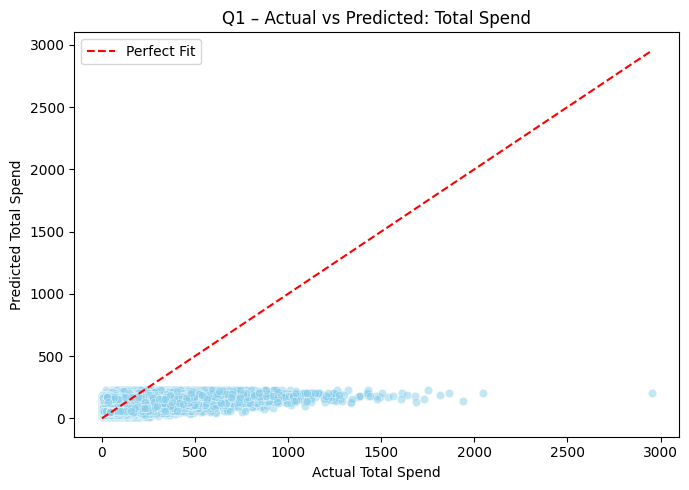

In [ ]:
# Get best model for tot_spend
best_combo_spend, _, _ = find_model(df, predictors, 'tot_spend')
X_spend = sm.add_constant(df[list(best_combo_spend)])
y_spend = df['tot_spend']
model_spend = sm.OLS(y_spend, X_spend).fit()
y_pred_spend = model_spend.predict(X_spend)

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_spend, y=y_pred_spend, alpha=0.5, color='skyblue')
plt.plot([y_spend.min(), y_spend.max()], [y_spend.min(), y_spend.max()], 'r--', label='Perfect Fit')
plt.title("Q1 – Actual vs Predicted: Total Spending")
plt.xlabel("Actual Total Spending")
plt.ylabel("Predicted Total Spending")
plt.legend()
plt.tight_layout()
plt.show()

<span style="color:#7E96A0"> **Units_sold**
This scatter plot visualizes the model's performance for **units sold** by comparing predicted values to the actual observed values. Dots near the diagonal line indicate strong predictive accuracy. This model gives insight into how product sales volume responds to price, placement, and promotions, helping retailers optimize merchandising strategies.
</span>

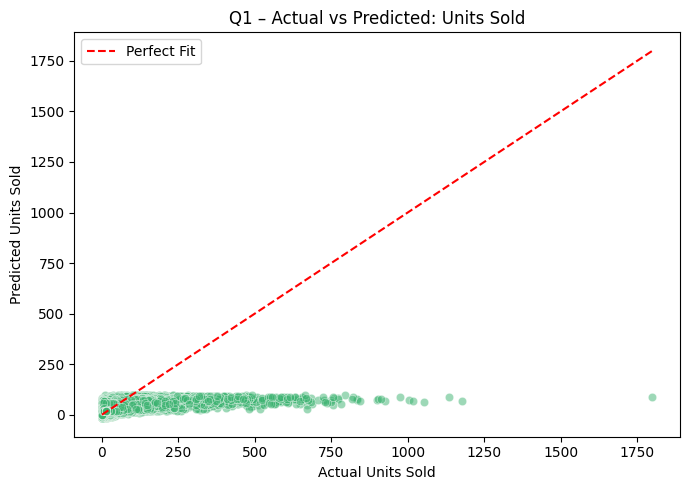

In [45]:
# Get best model for units_sold
best_combo_units, _, _ = find_model(df, predictors, 'units_sold')
X_units = sm.add_constant(df[list(best_combo_units)])
y_units = df['units_sold']
model_units = sm.OLS(y_units, X_units).fit()
y_pred_units = model_units.predict(X_units)

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_units, y=y_pred_units, alpha=0.5, color='mediumseagreen')
plt.plot([y_units.min(), y_units.max()], [y_units.min(), y_units.max()], 'r--', label='Perfect Fit')
plt.title("Q1 – Actual vs Predicted: Units Sold")
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

<span style="color:#7E96A0">
Below, we compare actual vs predicted values for the **number of household visits** to a store. Points clustered around the diagonal red dashed line suggest the model is reliably predicting store traffic. This visualization supports our analysis of how marketing activities influence foot traffic and consumer engagement.
</span>

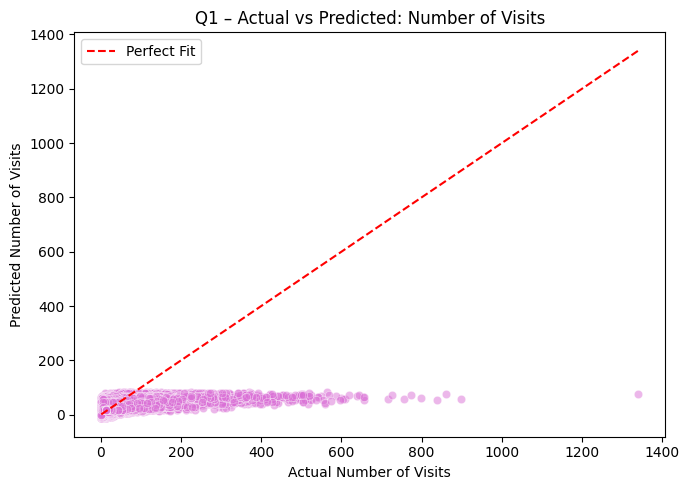

In [46]:
# Get best model for num_visits
best_combo_visits, _, _ = find_model(df, predictors, 'num_visits')
X_visits = sm.add_constant(df[list(best_combo_visits)])
y_visits = df['num_visits']
model_visits = sm.OLS(y_visits, X_visits).fit()
y_pred_visits = model_visits.predict(X_visits)

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_visits, y=y_pred_visits, alpha=0.5, color='orchid')
plt.plot([y_visits.min(), y_visits.max()], [y_visits.min(), y_visits.max()], 'r--', label='Perfect Fit')
plt.title("Q1 – Actual vs Predicted: Number of Visits")
plt.xlabel("Actual Number of Visits")
plt.ylabel("Predicted Number of Visits")
plt.legend()
plt.tight_layout()
plt.show()

<!-- ### <a id="q2_analysis"></a>Effect by Product Category & Store Segment  
[⬆️ Back to Top](#top)

<span style="color:#29AFCE">Q2. How do the effects of promotions, displays, or circulars vary by product categories (cold cereals, frozen pizza, bag snacks) and store segments (mainstream, upscale, value)?</span> -->

### <a id="q2_analysis"></a>Effect by Product Category & Store Segment  
[⬆️ Back to Top](#top)

<span style="color:#29AFCE">Q2. How do the effects of promotions, displays, or circulars vary by product categories (cold cereals, frozen pizza, bag snacks) and store segments (mainstream, upscale, value)?</span>

<span style="color:#7E96A0">
To address this question, we created interaction terms that combine the effects of promotional features (e.g., "feature") with specific product sub-categories and store segments. For example, the variable `feature_x_family_cereal` measures the effect of being featured *specifically* on family cereals, while `feature_x_segment_0` looks at how promotions perform in a particular store segment. These interactions help isolate which promotions work best for each category or segment, allowing more tailored marketing strategies across different product and store types.
</span>

In [47]:
interaction_vars = [
    'feature_x_family_cereal',
    'feature_x_kids_cereal',
    'feature_x_pizza',
    'feature_x_pretzels',
    'feature_x_segment_0',
    'feature_x_segment_1'
]

q2_results = {}

for var in interaction_vars:
    X = sm.add_constant(df[[var]])
    y = df['tot_spend']  # You could swap in 'units_sold' or 'num_visits' too
    model = sm.OLS(y, X).fit()
    q2_results[var] = model.rsquared

# Display the R² for each interaction to show explanatory strength
print("Q2 — R² Values for Category/Segment Interactions on Total Spend:")
for var, r2 in q2_results.items():
    print(f"  {var}: R² = {round(r2, 4)}")

Q2 — R² Values for Category/Segment Interactions on Total Spend:
  feature_x_family_cereal: R² = 0.0213
  feature_x_kids_cereal: R² = 0.0144
  feature_x_pizza: R² = 0.0309
  feature_x_pretzels: R² = 0.033
  feature_x_segment_0: R² = 0.1314
  feature_x_segment_1: R² = 0.108


/var/folders/z9/4yg2bxhd77z407m0mn8rmkdr0000gn/T/ipykernel_54572/1934603353.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="R_squared", y="Interaction_Term", data=q2_r2_df.sort_values(by="R_squared", ascending=True), palette="coolwarm")


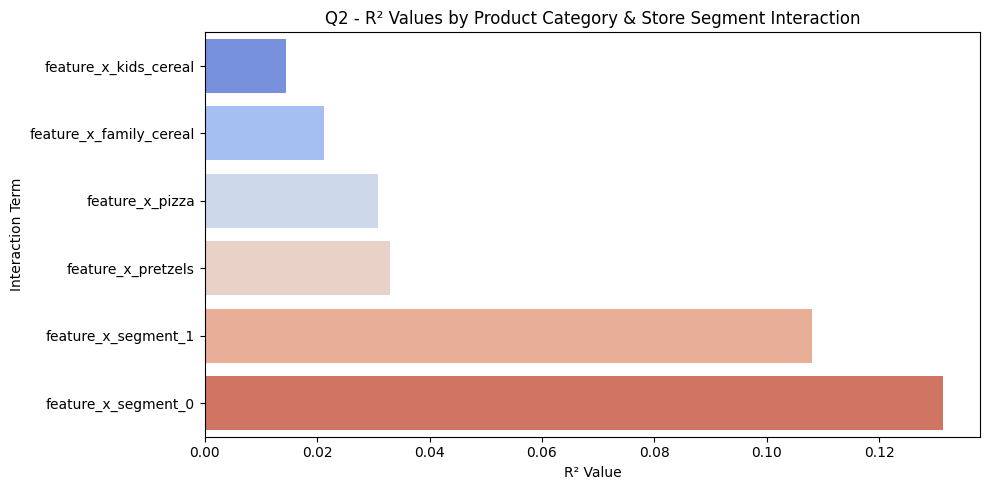

In [48]:
# Convert R² dictionary to DataFrame
q2_r2_df = pd.DataFrame(list(q2_results.items()), columns=["Interaction_Term", "R_squared"])

# Plot bar chart of R² values
plt.figure(figsize=(10, 5))
sns.barplot(x="R_squared", y="Interaction_Term", data=q2_r2_df.sort_values(by="R_squared", ascending=True), palette="coolwarm")
plt.title("Q2 - R² Values by Product Category & Store Segment Interaction")
plt.xlabel("R² Value")
plt.ylabel("Interaction Term")
plt.tight_layout()
plt.show()

### <a id="prc_elas"></a>Evaluate Price Elasticity  
[⬆️ Back to Top](#top)

<span style="color:#29AFCE">Q3. What are the five most price-elastic and five least price-elastic products? Price elasticity is the change in sales for a unit change in the product price</span>


##### Elasticity Calculation

In [49]:
elas = [] # Determine price elasticity of demand
for upc, group in df.groupby('upc'):
    if group['price'].nunique() > 1:
        X = sm.add_constant(group['price'])
        y = group['units_sold']
        model = sm.OLS(y, X).fit()
        coef = model.params['price']
        mean_price = group['price'].mean()
        mean_units = group['units_sold'].mean()
        elasticity = coef * (mean_price / mean_units)
        elas.append({
            'upc': upc,
            'elasticity': elasticity,
            'product': group['product'].iloc[0] if 'product' in group.columns else 'Unknown'
        })

elas_df = pd.DataFrame(elas)
elas_df = elas_df.merge(product_names, on='upc', how='left')
most_elas = elas_df.sort_values(by='elasticity').head(5)
least_elas = elas_df.sort_values(by='elasticity').tail(5)

##### Elastic Product Summary

In [50]:
print("Top 5 Most Price-Elastic Products (Highly sensitive to price changes):")
print(most_elas[['upc', 'description', 'elasticity']])
print('-----------------------')
print("Top 5 Least Price-Elastic Products (Less sensitive to price changes):")
print(least_elas[['upc', 'description', 'elasticity']])

Top 5 Most Price-Elastic Products (Highly sensitive to price changes):
             upc                description  elasticity
19  3.000007e+09  qker cap n crunch berries   -8.753282
23  3.800039e+09           kell froot loops   -6.733868
20  3.000007e+09          qker cap n crunch   -6.131679
34  7.218064e+09       frsc pepperoni pizza   -5.561828
33  7.218063e+09   frsc brck ovn itl pep pz   -5.293509
-----------------------
Top 5 Least Price-Elastic Products (Less sensitive to price changes):
             upc               description  elasticity
25  7.027316e+09      shurgd mini pretzels   -0.357705
3   1.111085e+09  pl honey nut toastd oats    0.268386
1   1.111009e+09         pl pretzel sticks    1.339258
2   1.111010e+09         pl twist pretzels    1.791664
0   1.111009e+09    pl mini twist pretzels    1.855814


<span style="color:#7E96A0">These R² values show that while promotions, displays, and store-related factors do have a measurable effect, there are other factors not included in the model that influence spending, purchases, and visits. For example, the tarriffs that have been in the news lately can play a role in grocery spending. However incoroporating such variables is eyond the score of this project. In short, we've identified important marketing levers, but there’s still room to improve the model’s explanatory power with more data or variables</span>

/var/folders/z9/4yg2bxhd77z407m0mn8rmkdr0000gn/T/ipykernel_54572/1767983588.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[0], y=most_elas['description'], x=most_elas['elasticity'], palette='viridis')
/var/folders/z9/4yg2bxhd77z407m0mn8rmkdr0000gn/T/ipykernel_54572/1767983588.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[1], y=least_elas['description'], x=least_elas['elasticity'], palette='magma')


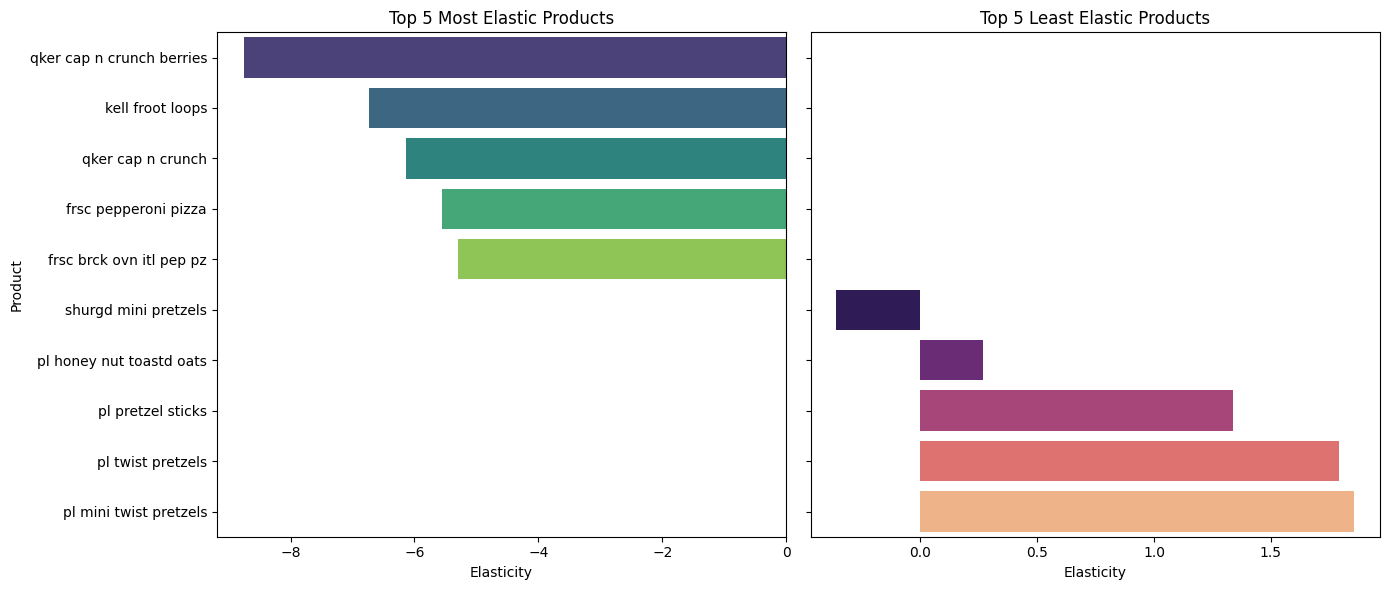

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Top 5 Most Elastic
sns.barplot(ax=axs[0], y=most_elas['description'], x=most_elas['elasticity'], palette='viridis')
axs[0].set_title("Top 5 Most Elastic Products")
axs[0].set_xlabel("Elasticity")
axs[0].set_ylabel("Product")

# Top 5 Least Elastic
sns.barplot(ax=axs[1], y=least_elas['description'], x=least_elas['elasticity'], palette='magma')
axs[1].set_title("Top 5 Least Elastic Products")
axs[1].set_xlabel("Elasticity")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()

### <a id="prc_strat"></a>Pricing Strategy, Changes, and Recommendations  
[⬆️ Back to Top](#top)

<span style="color:#29AFCE">Q4. As the retailer, which products would you lower the price to maximize (a) product sales and (b) unit sales, and why?</span>

<span style="color:#7E96A0">A 1% change in price results in the following positive or negtative demand (units sold). Elasticity means that there is an inverse relaitonship between the price and sales. Decreasing the price of a highly elastic product by 1% results in an increase in demand. The negative sign represents the inverse relationship between price and demand.</span>

In [52]:
print("Retail Pricing Strategy Recommendations")
print('-----------------------')
print("Recommendation: Lower prices for the most elastic products to increase revenue and unit sales:")
for _, row in most_elas.iterrows():
    print(f"  - {row['description'].title()} (Elasticity: {round(row['elasticity'], 2)})")

Retail Pricing Strategy Recommendations
-----------------------
Recommendation: Lower prices for the most elastic products to increase revenue and unit sales:
  - Qker Cap N Crunch Berries (Elasticity: -8.75)
  - Kell Froot Loops (Elasticity: -6.73)
  - Qker Cap N Crunch (Elasticity: -6.13)
  - Frsc Pepperoni Pizza (Elasticity: -5.56)
  - Frsc Brck Ovn Itl Pep Pz (Elasticity: -5.29)




<span style="color:#7E96A0">These products show high responsiveness to price changes. Lowering prices is likely to result in a significant increase in both sales volume and revenue</span>